### Installing Required Libraries

The following command installs essential libraries for our project:

- **`torch` & `torchvision`**: PyTorch, a deep learning framework, and its companion library for handling computer vision tasks.
- **`numpy`**: A fundamental library for numerical computing in Python, used for array manipulation and operations.
- **`matplotlib`**: A plotting library to visualize data and results in the form of graphs and plots.
- **`transformers`**: Hugging Face's library for state-of-the-art pre-trained models, especially used in NLP tasks.
- **`mahotas`**: A library for image processing and computer vision, helpful for tasks like filtering and feature extraction.

Run the cell below to install these libraries. If you’re using Google Colab, these installations are required to ensure all dependencies are available for execution.

```bash
!pip install torch torchvision numpy matplotlib transformers mahotas


In [1]:
!pip install torch torchvision numpy matplotlib transformers mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.9 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip", 'r')
zip_ref.extractall("/content/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1")
zip_ref.close()

Displaying slices for: 112.nii


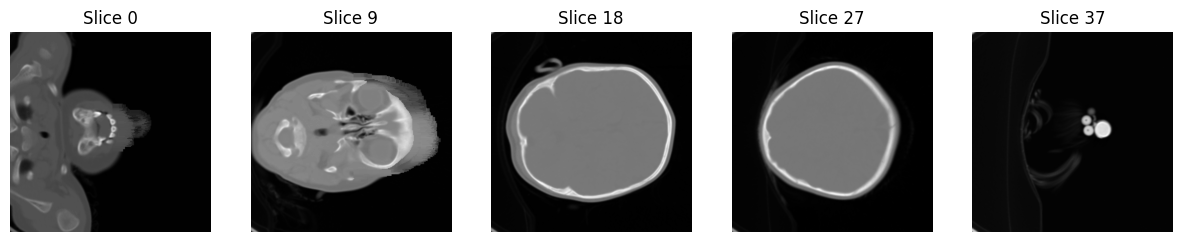

Displaying slices for: 113.nii


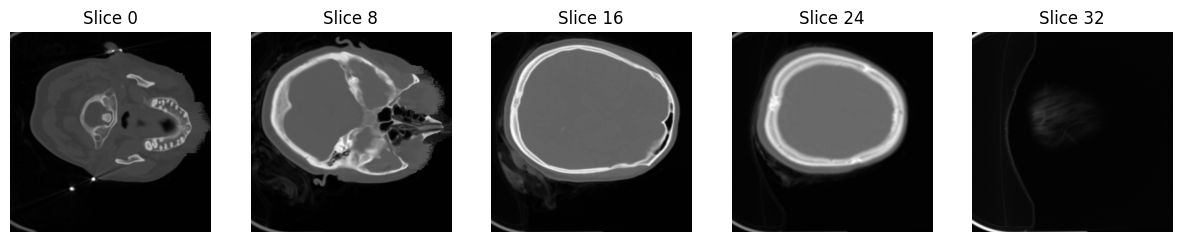

Displaying slices for: 123.nii


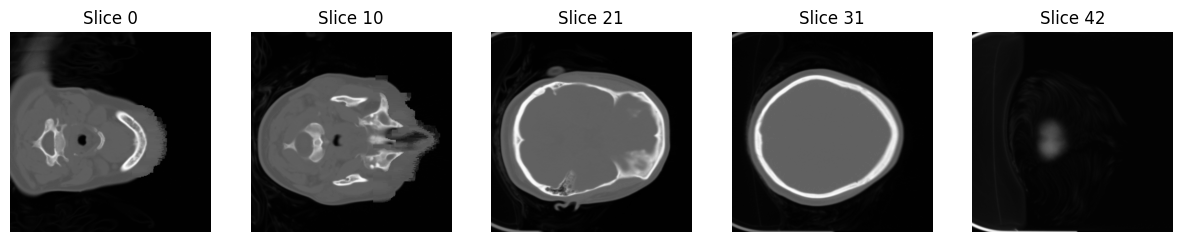

In [4]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
def show_nifti_slices(image, num_slices=5):
    data = image.get_fdata()
    z_slices = data.shape[2]

    slice_indices = np.linspace(0, z_slices - 1, num_slices, dtype=int)

    plt.figure(figsize=(15, 3 * num_slices))

    for i, slice_idx in enumerate(slice_indices):
        plt.subplot(1, num_slices, i + 1)
        plt.imshow(data[:, :, slice_idx], cmap="gray")
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')

    plt.show()

ct_scan_dir = "/content/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans"

for idx, filename in enumerate(os.listdir(ct_scan_dir)):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        file_path = os.path.join(ct_scan_dir, filename)
        image = nib.load(file_path)

        print(f"Displaying slices for: {filename}")
        show_nifti_slices(image)

        if idx >= 2:
            break


In [5]:
import os
import torch
import nibabel as nib
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel, Trainer, TrainingArguments
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
from huggingface_hub import hf_hub_download

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to("cuda")

def load_nii_as_image(nii_path, slice_index=None):
    nii_image = nib.load(nii_path)
    nii_data = nii_image.get_fdata()
    num_slices = nii_data.shape[2]

    if slice_index is None:
        slice_index = num_slices // 2

    if slice_index < 0 or slice_index >= num_slices:
        raise IndexError(f"Slice index {slice_index} is out of bounds for the NIfTI image with {num_slices} slices.")

    slice_2d = nii_data[:, :, slice_index]
    slice_2d_normalized = ((slice_2d - slice_2d.min()) / (slice_2d.max() - slice_2d.min()) * 255).astype(np.uint8)
    slice_image = Image.fromarray(slice_2d_normalized).convert("RGB")
    return slice_image

def preprocess_image(img):
    inputs = feature_extractor(images=img, return_tensors="pt").to("cuda")
    return inputs

def extract_features_vit(model, img_tensor):
    with torch.no_grad():
        features = model(**img_tensor).last_hidden_state
    return features.mean(dim=1)

ct_scan_dir = "/content/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/ct_scans"
feature_vectors = {}

# Extract features for each CT scan slice for hemorrhage detection
for filename in os.listdir(ct_scan_dir):
    if filename.endswith('.nii'):
        nii_path = os.path.join(ct_scan_dir, filename)
        try:
            slice_image = load_nii_as_image(nii_path)
            img_tensor = preprocess_image(slice_image)
            features = extract_features_vit(vit_model, img_tensor)
            feature_vectors[filename] = features
            print(f"Extracted features for {filename}")
        except IndexError as e:
            print(f"Error processing {filename}: {e}")

torch.save(feature_vectors, "vit_features.pt")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Extracted features for 112.nii
Extracted features for 113.nii
Extracted features for 123.nii
Extracted features for 109.nii
Extracted features for 056.nii
Extracted features for 117.nii
Extracted features for 068.nii
Extracted features for 101.nii
Extracted features for 097.nii
Extracted features for 079.nii
Extracted features for 067.nii
Extracted features for 108.nii
Extracted features for 086.nii
Extracted features for 072.nii
Extracted features for 095.nii
Extracted features for 081.nii
Extracted features for 105.nii
Extracted features for 106.nii
Extracted features for 115.nii
Extracted features for 091.nii
Extracted features for 121.nii
Extracted features for 077.nii
Extracted features for 051.nii
Extracted features for 076.nii
Extracted features for 070.nii
Extracted features for 118.nii
Extracted features for 103.nii
Extracted features for 074.nii
Extracted features for 088.nii
Extracted features for 055.nii
Extracted features for 128.nii
Extracted features for 092.nii
Extracte

In [ ]:
import os
os._exit(00)

In [ ]:
import torch
from diffusers import DiffusionPipeline, UNet2DConditionModel, LCMScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file
from PIL import Image

base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
repo_name = "tianweiy/DMD2"
ckpt_name = "dmd2_sdxl_4step_unet_fp16.bin"

unet = UNet2DConditionModel.from_config(base_model_id, subfolder="unet").to("cuda", torch.float16)
unet.load_state_dict(torch.load(hf_hub_download(repo_name, ckpt_name), map_location="cuda"))
pipe = DiffusionPipeline.from_pretrained(base_model_id, unet=unet, torch_dtype=torch.float16).to("cuda")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

vit_features = torch.load("vit_features.pt")
generated_images = []
import os

os.makedirs("gen", exist_ok=True)
# Generate images and save for re-training
for filename, feature_vector in vit_features.items():
    prompt = f"A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of {filename}. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model."
    print(f"Generating image with prompt: {prompt}")

    image = pipe(
        prompt=prompt,
        num_inference_steps=4,
        guidance_scale=7.5,
        condition=feature_vector
    ).images[0]


    generated_images.append(image)
    image.save(f"gen/generated_{filename}.png")
    print(f"Image saved as 'gen/generated_{filename}.png'")


# Define Dataset class for fine-tuning ViT
class CTScanDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transform:
            img = self.transform(img)
        return img

# Create a Dataset and DataLoader for the generated images
dataset = CTScanDataset(generated_images)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Fine-tune ViT on the generated images
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    save_steps=10,
    logging_dir="./logs",
)

trainer = Trainer(
    model=vit_model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()


<ipython-input-4-561f5da09a1c>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(hf_hub_download(repo_name, ckpt_name), map_location="cuda"))

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.
<ipython-input-4-561f5da09a1c>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file.

Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 112.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_112.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 113.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_113.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 123.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_123.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 109.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_109.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 056.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_056.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 117.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_117.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 068.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_068.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 101.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_101.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 097.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_097.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 079.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_079.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 067.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_067.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 108.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_108.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 086.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_086.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 072.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_072.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 095.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_095.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 081.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_081.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 105.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_105.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 106.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_106.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 115.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_115.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 091.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_091.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 121.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_121.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 077.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_077.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 051.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_051.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 076.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_076.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 070.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_070.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 118.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_118.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 103.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_103.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 074.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_074.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 088.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_088.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 055.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_055.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 128.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_128.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 092.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_092.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 054.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_054.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 066.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_066.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 089.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_089.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 102.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_102.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 111.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_111.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 087.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_087.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 050.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_050.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 107.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_107.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 082.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_082.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 126.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_126.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 114.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_114.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 122.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_122.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 053.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_053.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 129.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_129.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 093.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_093.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 098.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_098.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 124.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_124.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 100.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_100.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 080.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_080.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 090.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_090.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 116.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_116.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 094.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_094.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 075.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_075.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 073.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_073.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 069.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_069.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 096.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_096.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 130.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_130.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 078.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_078.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 084.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]

Image saved as 'gen/generated_084.nii.png'
Generating image with prompt: A high-resolution, grayscale CT scan of the brain, accurately capturing detailed anatomical structures, inspired by the feature vector of 104.nii. This image should depict realistic tissue density variations, with clear representation of bones, soft tissues, and any hemorrhagic areas, suitable for medical analysis and further training in a ViT model.


  0%|          | 0/4 [00:00<?, ?it/s]